# Demand Forecasting Notebook using SARIMA

This notebook uses SARIMA forecasting

## Set up project id, dependencies and environment variables

### Set up project id

In [ ]:
%env GOOGLE_CLOUD_PROJECT= <nameofyouraccount>
!gcloud config set project <nameofyouraccount>

### Dependencies

In [133]:
install_dependencies = False
if install_dependencies:
    !pip install plotly==4.12.0
    !pip install pmdarima
    !pip install pystan
    !pip install fbprophet

In [134]:
#Import Data and Viz Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

#Import Math, Systems and Date Libraries
import math
import sys
import os
import warnings
import datetime
import pickle
import itertools
warnings.filterwarnings("ignore")

#Stats Library
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

#Evaluation metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#Facebook Prophet Libraries
from fbprophet import Prophet

#Tensorflow library
import tensorflow as tf

#Google Cloud Libraries
from google.cloud import bigquery as bq

### Environment Variables

In [135]:
PROJECT_ID = os.environ["GOOGLE_CLOUD_PROJECT"] # Do not Change
TIMESERIES_DATASET = '0_temp'
TRAIN_TABLE = 'training_table_annie'
PREDICTIONS_TABLE = 'prediction_table_annie' # used for evaluating the model
RESULTS_TABLE = 'results_annie'
TEMP_TABLE_PREFIX = 'temp_table_annie' # this will be appened with a date
LABEL_COLUMN = "dependent"

TARGET_DAY_WINDOW_TRAIN = 30 # How many days do we want to forecast for
LOOKBACK_WINDOW_DAYS = 413 # This is how far back in the user's history we are using to train
#TRAINING_SQL_PATH = '/home/jupyter/forecasting/sarima/sql/order_shipment.sql' #Change if using GA or backend figures

SOURCE_PROJECT_ID = <yourprojectid>
DATASET_ID = 'aggregation' 
TABLE_PREFIX = "order_shipment" 

END_DATE = datetime.date.today()
START_DATE = END_DATE - datetime.timedelta(days=413)

Google Analytics data we use the **_TABLE_SUFFIX** option. And the date format for this option is "YYYYMMDD".

If using_ga_data is set to True it will convert **END_DATE** and **START_DATE** to the format "YYYYMMDD". 

If using_ga_data is to False the date format will be "YYYY-MM-DD".

In [136]:
using_ga_data = True
if using_ga_data:
    END_DATE = str(END_DATE).replace("-","")
    START_DATE = str(START_DATE).replace("-","")
    DATA_TYPE = "STRING"
    TRAINING_SQL_PATH = 'sql/ga_orders.sql' 
else:
    DATA_TYPE = "DATE"
    TRAINING_SQL_PATH = 'sql/order_shipment.sql' 
print(f'Training end date is {END_DATE}\nTraining start date is {START_DATE}\nDATA_TYPE is {DATA_TYPE}')

Training end date is 20210302
Training start date is 20200114
DATA_TYPE is STRING


**save_to_pickle** to save the latest version of the data to a pickle file for quicker data reads in the future

**load to_pickle** to load the latest version of the data from a pickle file. Considerably quicker than calling BigQuery API. 

In [137]:
save_to_pickle = False
load_from_pickle = False

## Define Get BigQuery Data Functions

If using Google Analytics Data we need to use DATA TYPE **"STRING"** else we use **"DATE"**

In [138]:
##using_ga_data = False
##if using_ga_data:
##    DATA_TYPE = "STRING"
##else:
##    DATA_TYPE = "DATE"
##print(f'DATA_TYPE is {DATA_TYPE}')

In [139]:
def bq_job_config(start_date,end_date):   
    job_config = bq.QueryJobConfig(
        query_parameters=[
            bq.ScalarQueryParameter("start_date", DATA_TYPE, start_date),#change to type DATE if not using GA table
            bq.ScalarQueryParameter("end_date", DATA_TYPE,end_date) #change to type DATE if not using GA table
        ])
    return job_config

In [140]:
def generate_sql(sql_,project_id,start_date,end_date):
    
    client = bq.Client(project=project_id)
    job_config = bq_job_config(start_date,end_date)
    print(job_config)
    try:
        print("Try Block")
        query = client.query(sql_,job_config=job_config)
    except:
        print("Error in query")
    return query

In [141]:
def get_data(sql_, project_id, start_date, end_date):
    client = bq.Client(project=project_id)
    job_config = bq_job_config(start_date,end_date)
    try:
        df = client.query(sql_,job_config=job_config)
    except:
        print("Error getting data")    
    df = df.to_dataframe(progress_bar_type='tqdm') # Converts to dataframe
    
    return df

In [142]:
def add_to_table(dest_table_id, sql,bq_table_exists=True):
    
    # Construct a BigQuery client object.
    client = bq.Client()
    
    if bq_table_exists:
        write_disposition = "WRITE_TRUNCATE"
    else:
        write_disposition = "WRITE_EMPTY"
    
    job_config = bq.QueryJobConfig(
        # Set our destination table
        destination=dest_table_id,
        
        # setting to add to the destination table if it already exists 
        write_disposition= write_disposition,
        create_disposition='CREATE_IF_NEEDED'
    )
    
    query_job = client.query(sql, job_config=job_config, )  # Make an API request.
    query_job.result() # Wait for result

    return

In [143]:
def create_model_job_config():
    
    job_config = bq.QueryJobConfig()
    
    return job_config

In [144]:
def create_bqml_model(sql_):
    # Construct a BigQuery client object.
    client = bq.Client()
    job_config = create_model_job_config()    
    query_job = client.query(sql_, job_config=job_config)  # Make an API request.
    query_job.result() # Wait for result

    return query_job.result()

In [145]:
def is_stationary(ts, maxlag=15, autolag=None, regression='ct'): 
    """Test if ts is stationary using Augmented Dickey Fuller test""" 

    adf_test = adfuller(ts,maxlag=maxlag, autolag=autolag, regression=regression) 
    adf = adf_test[0]
    cv_5 = adf_test[4]["5%"]
 #p value > alpha, series not stationary
    result = adf < cv_5    
    return result

In [146]:
def n_diffs(ts, max_lag=12):
    '''Check the order of differencing necessary to make ts stationary'''
    ndiff= 0
    for i in range(1, max_lag):
        if is_stationary(ts.diff(i).dropna()):
            ndiff = i
            break;
    return ndiff

## Get Training Data into Pandas DataFrame

Here we get the training data into a Pandas DataFrame.

If you are not running a new query or a different date than above just read from pickle if not read new query.

In [ ]:
if load_from_pickle:
    training_data_df = pd.read_pickle("pickle/training_data_annie_2020.pkl")
    training_data_df.head()
else:
    sql_ = open(TRAINING_SQL_PATH,"r").read()    
    sql_ = sql_.replace("@start_date",'"'+ str(START_DATE) + '"')
    sql_ = sql_.replace("@end_date",'"'+ str(END_DATE) + '"')
    print(sql_)    
    training_data_df = get_data(sql_,project_id=PROJECT_ID,start_date=START_DATE,end_date=END_DATE)
    training_data_df.head()

In [156]:
training_data_df.shape

(413, 2)

**Saved data to pickle** this is useful for quicker load times instead of calling BigQuery API.
Always save to pickle if you ran the query and printed out new data. 

In [157]:
if save_to_pickle:
    training_data_df.to_pickle('pickle/training_data_annie_2020.pkl')

In [158]:
training_data_df

,date,dependent
0,20200114,2857
1,20200115,2524
2,20200116,2478
3,20200117,2918
4,20200118,3420
...,...,...
408,20210225,6640
409,20210226,7528
410,20210227,7870
411,20210228,8037


In [159]:
#convert date to datetime type in case it is not 
training_data_df['date'] = pd.to_datetime(training_data_df['date'])

#Set date as the index with annual frequency
training_data_df.set_index(pd.DatetimeIndex(training_data_df['date']),inplace=True)
training_data_df.drop(['date'],inplace=True,axis=1)

 #training_data_df.index.freq = 'm'

In [160]:
training_data_df.index

DatetimeIndex(['2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
               '2020-01-18', '2020-01-19', '2020-01-20', '2020-01-21',
               '2020-01-22', '2020-01-23',
               ...
               '2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23',
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27',
               '2021-02-28', '2021-03-01'],
              dtype='datetime64[ns]', name='date', length=413, freq=None)

In [161]:
sample = training_data_df

## Data Exploration

Key things to identify in this section are seasonality, trends and outliers. 

### Current Data
The key thing with this graph is to notice any outliers and also look for seasonality.

Remember SARIMA performs better with a clear seasonality and a clear trend.

Use MATPLOTPLIB commented code when you have a issue with Ploty on your Jupyter Notebook.

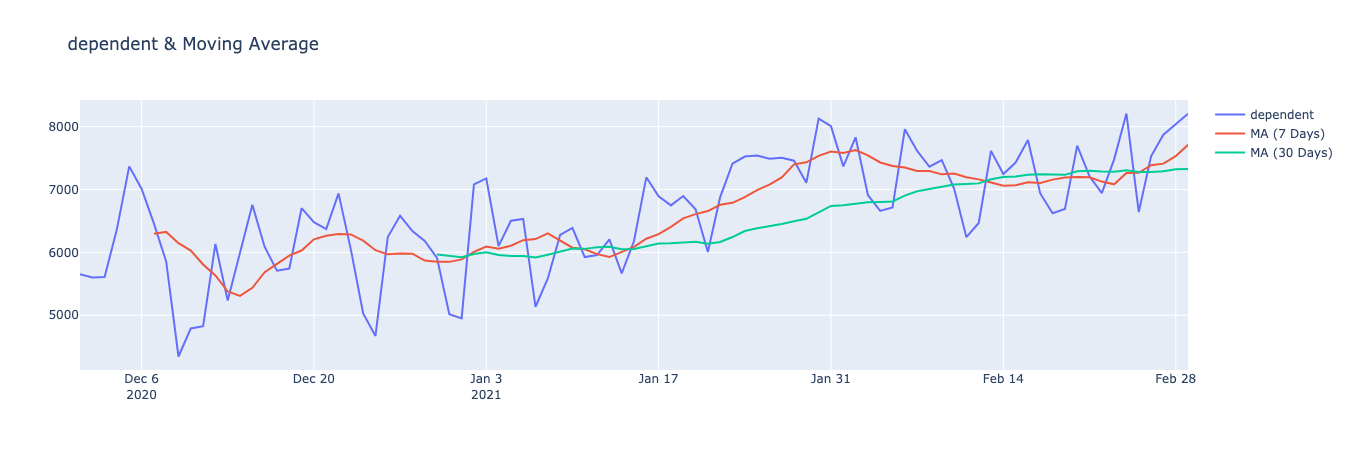

In [188]:
##Plotly
fig = go.Figure()
fig.add_trace(go.Line(x=training_data_df.index,y=training_data_df["dependent"],name="dependent"))
fig.add_trace(go.Line(x=training_data_df.index,y=training_data_df.dependent.rolling(7).mean(),name="MA (7 Days)"))
fig.add_trace(go.Line(x=training_data_df.index,y=training_data_df.dependent.rolling(30).mean(),name="MA (30 Days)"))
fig.update_layout(title="dependent & Moving Average")
fig.show()

##MATPLOTLIB Comment out if you get a error presenting your figures with Plotly.
#fig, ax = plt.subplots(figsize=(20,10))
#sns.lineplot(x="date",y='dependent',data=training_data_df)

In [162]:
training_data_df = training_data_df.loc['2020-12-01':]
training_data_df

,dependent
date,
2020-12-01,5652
2020-12-02,5600
2020-12-03,5607
2020-12-04,6371
2020-12-05,7367
...,...
2021-02-25,6640
2021-02-26,7528
2021-02-27,7870


### Seasonal Decomposition
We want to see the trends, seasonality and residuals.

This will let us us know if SARIMA is really a useful model for this. 

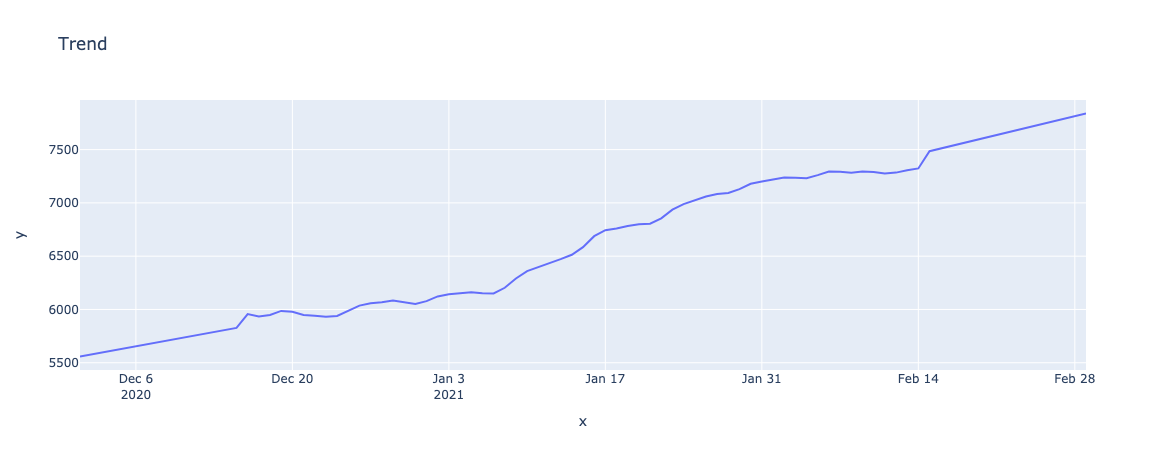

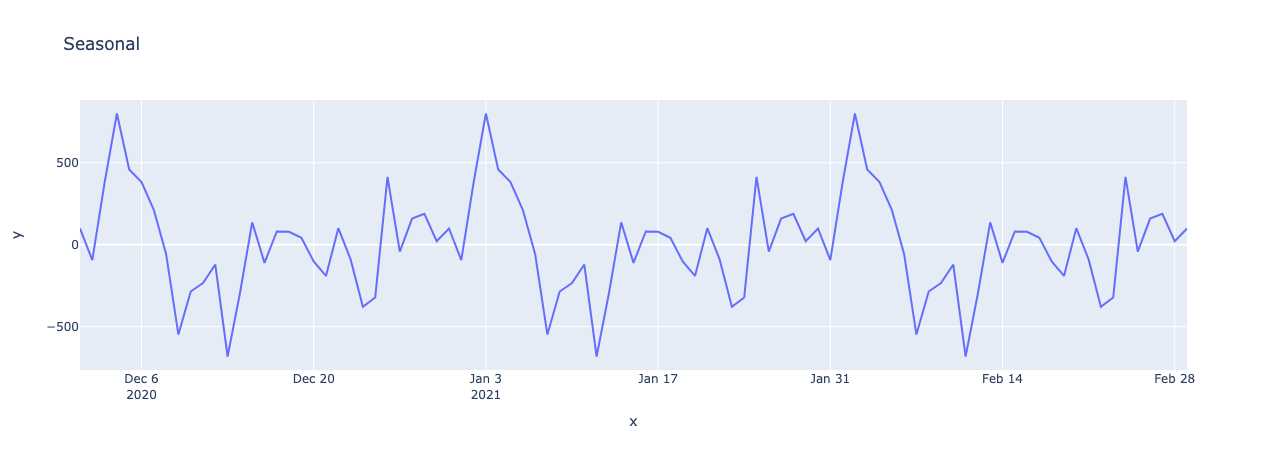

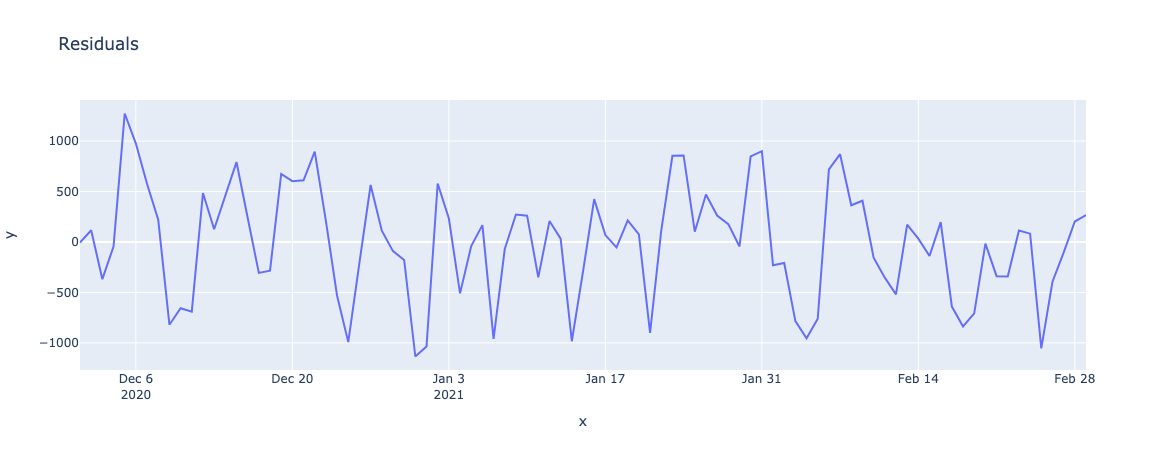

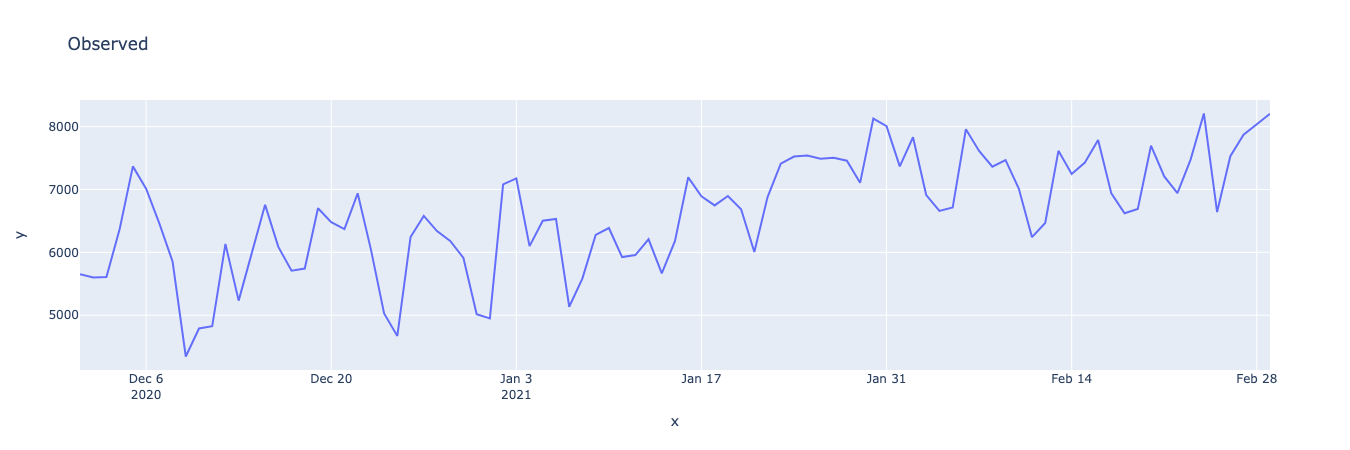

In [163]:
results = seasonal_decompose(training_data_df['dependent'],model="additive",period=30,extrapolate_trend = 30)
fig1 = px.line(results.trend,x=training_data_df.index,y=results.trend, title="Trend")
fig2 = px.line(results.seasonal,x=training_data_df.index,y=results.seasonal, title="Seasonal")
fig3 = px.line(results.resid,x=training_data_df.index,y=results.resid, title="Residuals")
fig4 = px.line(results.observed,x=training_data_df.index,y=results.observed, title="Observed")
fig1.show()
fig2.show()
fig3.show()
fig4.show()

## SARIMA Model
This section will find the optimum PDQ values and create a forecast for evaluation.

### Identifying the best PDQ values

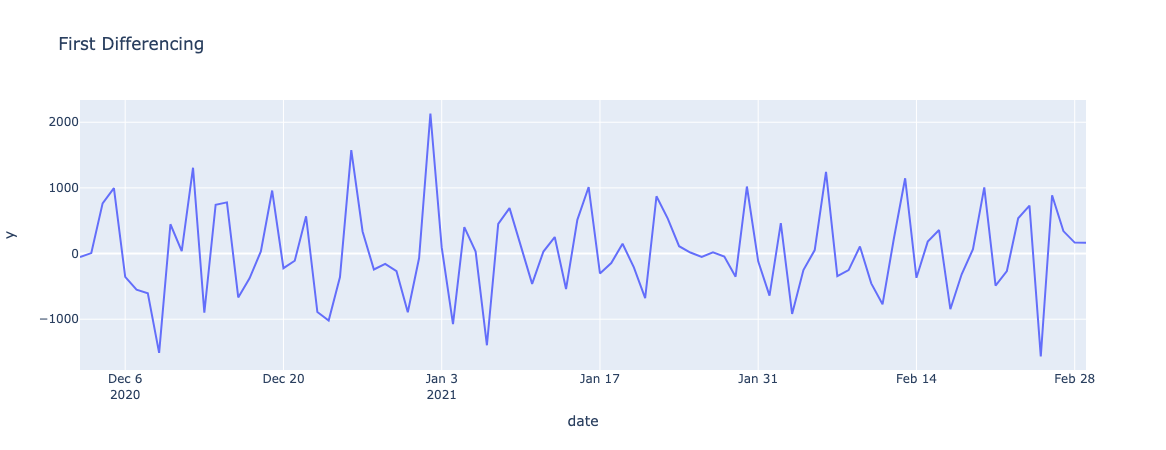

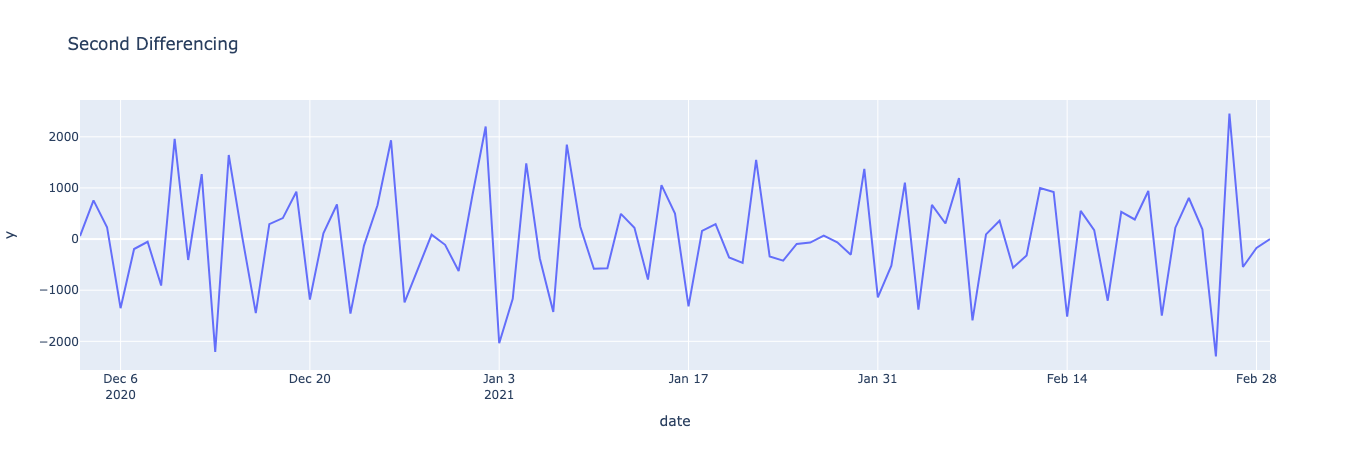

In [164]:
first_diff_ts = training_data_df['dependent'].diff().dropna()
scnd_diff_ts= training_data_df['dependent'].diff().diff().dropna()
fig1 = px.line(first_diff_ts,x=first_diff_ts.index,y=first_diff_ts, title="First Differencing")
fig2 = px.line(scnd_diff_ts,x=scnd_diff_ts.index,y=scnd_diff_ts, title="Second Differencing")
fig1.show()
fig2.show()

### check for stationarity 
The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

In [165]:
n_diffs(training_data_df)

0

In [166]:
is_stationary(training_data_df)

False

The time series reaches stationarity with two orders of differencing.

### Visually 

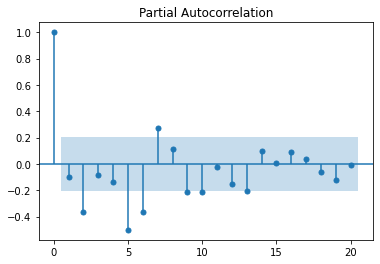

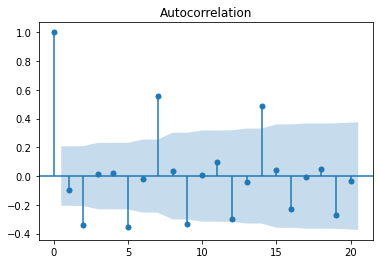

In [167]:
plot_pacf(first_diff_ts);
plot_acf(first_diff_ts);

In [168]:
#training_data_df = pd.DataFrame(first_diff_ts) #remember to de-difference if you enter differenced ts into the model
training_data_df

,dependent
date,
2020-12-01,5652
2020-12-02,5600
2020-12-03,5607
2020-12-04,6371
2020-12-05,7367
...,...
2021-02-25,6640
2021-02-26,7528
2021-02-27,7870


In [170]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 30) for x in list(itertools.product(p, d, q))]

In [171]:
results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(training_data_df['dependent'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            aic = round(results.aic,2)
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, round(results.aic,2)))
            results_list.append([param,param_seasonal, round(results.aic,2) ])
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 30) - AIC:1843.04
ARIMA(0, 0, 0)x(0, 0, 1, 30) - AIC:2643.44
ARIMA(0, 0, 0)x(0, 1, 0, 30) - AIC:1023.53
ARIMA(0, 0, 0)x(0, 1, 1, 30) - AIC:510.41
ARIMA(0, 0, 0)x(1, 0, 0, 30) - AIC:1025.6
ARIMA(0, 0, 0)x(1, 0, 1, 30) - AIC:1009.88
ARIMA(0, 0, 0)x(1, 1, 0, 30) - AIC:533.33
ARIMA(0, 0, 0)x(1, 1, 1, 30) - AIC:499.97
ARIMA(0, 0, 1)x(0, 0, 0, 30) - AIC:1761.95
ARIMA(0, 0, 1)x(0, 0, 1, 30) - AIC:6100.81
ARIMA(0, 0, 1)x(0, 1, 0, 30) - AIC:983.78
ARIMA(0, 0, 1)x(0, 1, 1, 30) - AIC:479.03
ARIMA(0, 0, 1)x(1, 0, 0, 30) - AIC:1014.3
ARIMA(0, 0, 1)x(1, 0, 1, 30) - AIC:978.54
ARIMA(0, 0, 1)x(1, 1, 0, 30) - AIC:518.34
ARIMA(0, 0, 1)x(1, 1, 1, 30) - AIC:468.6
ARIMA(0, 1, 0)x(0, 0, 0, 30) - AIC:1415.93
ARIMA(0, 1, 0)x(0, 0, 1, 30) - AIC:931.74
ARIMA(0, 1, 0)x(0, 1, 0, 30) - AIC:996.59
ARIMA(0, 1, 0)x(0, 1, 1, 30) - AIC:474.26
ARIMA(0, 1, 0)x(1, 0, 0, 30) - AIC:944.91
ARIMA(0, 1, 0)x(1, 0, 1, 30) - AIC:932.2
ARIMA(0, 1, 0)x(1, 1, 0, 30) - AIC:490.72
ARIMA(0, 1, 0)x(1, 1, 1, 30) 

In [172]:
result_df = pd.DataFrame(results_list)
result_df.columns = ['params', 'param_seasonal', 'AIC']
#Sort in ascending order, lower AIC is better
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
print(result_df.shape)
result_df.head()

(64, 3)


,params,param_seasonal,AIC
0,"(1, 1, 1)","(0, 1, 1, 30)",451.55
1,"(1, 1, 1)","(1, 1, 1, 30)",453.61
2,"(0, 1, 1)","(0, 1, 1, 30)",456.90
3,"(0, 1, 1)","(1, 1, 1, 30)",458.71
4,"(0, 0, 1)","(1, 1, 1, 30)",468.60


Our best model is (1,0,1)x(1,1,1,30) with an AIC of 5769. Let's validate it using Auto_arima.

In [141]:
auto_arima(training_data_df['dependent'],seasonal=True,m=15,maxiter=100,max_p=20,max_q=20,max_d=2,max_P=14,max_Q=14).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  411
Model:               SARIMAX(2, 0, 2)   Log Likelihood               -3352.004
Date:                Wed, 17 Feb 2021   AIC                           6714.007
Time:                        05:55:33   BIC                           6734.100
Sample:                             0   HQIC                          6721.956
                                - 411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2760      0.166     -1.662      0.096      -0.601       0.049
ar.L2          0.2115      0.099      2.131      0.033       0.017       0.406
ma.L1         -0.0928      0.166     -0.558      0.577      -0.419       0.233
ma.L2         -0.5811      0.161     -3.602      0.000      -0.897      -0.265
sigma2      7.294e+05   2.33e+04     31.254      0.000    6.84e+05    7.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2711.16
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.13
Prob(H) (two-sided):                  0.04   Kurtosis:                        15.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Building the SARIMA Model

In [202]:
cutoff = len(training_data_df)- 17

In [203]:
#Split the dataset
sarima_train = training_data_df.iloc[:cutoff] ## Change these if you want to change the training date range
sarima_test = training_data_df.iloc[cutoff:]  ## Change these if you want to change the test date range
print(f'Length of train data is {len(sarima_train)}\nLength of test data is {len(sarima_test)}')

Length of train data is 74
Length of test data is 17


In [204]:
sarima_model = SARIMAX(sarima_train["dependent"],order=(1,1,1),seasonal_order = (0, 1, 1, 30),enforce_stationarity = False) ## Add latest orders from auto_arima output
sarima_results = sarima_model.fit()
sarima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          dependent   No. Observations:                   74
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 30)   Log Likelihood                 -88.259
Date:                            Tue, 02 Mar 2021   AIC                            184.519
Time:                                    11:24:12   BIC                            186.110
Sample:                                12-01-2020   HQIC                           183.516
                                     - 02-12-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5696      0.480     -1.186      0.235      -1.510       0.371
ma.L1          1.0000     25.259      0.040      0.968     -48.507      50.507
ma.S.L30      -0.9975     19.750     -0.051      0.960     -39.707      37.712
sigma2       4.15e+05   5.69e+06      0.073      0.942   -1.07e+07    1.16e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                15.19
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             2.13
Prob(H) (two-sided):                  0.82   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [205]:
#Getting start and end dates from model
start = len(sarima_train)
end = start + len(sarima_test) - 1

In [206]:
len(sarima_test)

17

In [207]:
sarima_predictions = sarima_results.predict(start=start,end=end,typ="levels").rename("SARIMAX(1,0,1)x(1,1,1,30)")

In [215]:
sarima_test

,dependent
date,
2021-02-13,7614
2021-02-14,7245
2021-02-15,7427
2021-02-16,7785
2021-02-17,6937
2021-02-18,6621
2021-02-19,6688
2021-02-20,7696
2021-02-21,7208


In [209]:
sarima_test

,dependent
date,
2021-02-13,7614
2021-02-14,7245
2021-02-15,7427
2021-02-16,7785
2021-02-17,6937
2021-02-18,6621
2021-02-19,6688
2021-02-20,7696
2021-02-21,7208


In [ ]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

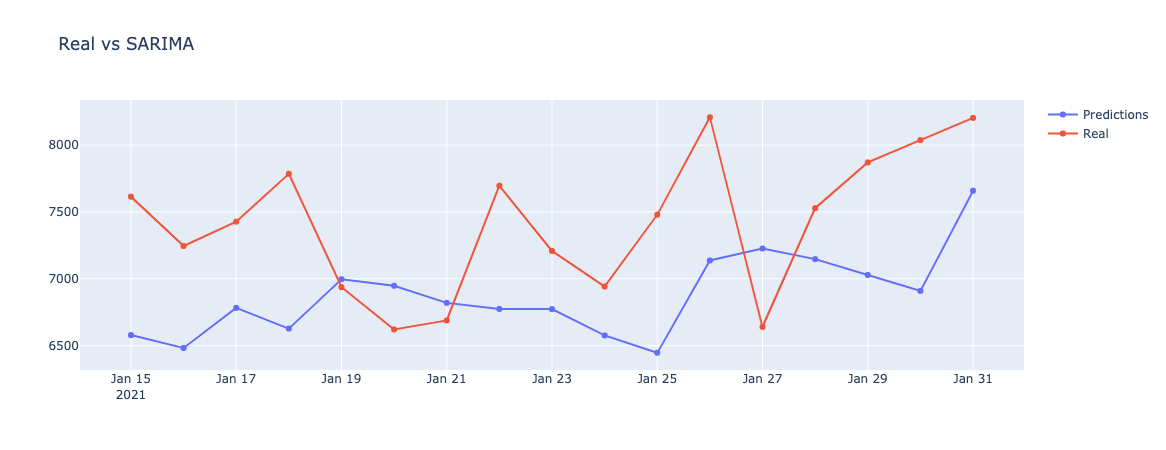

In [211]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=training_data_df.loc["2021-01-15":"2021-02-28"].index,y=sarima_predictions,name="Predictions"))
fig.add_trace(go.Line(x=training_data_df.loc["2021-01-15":"2021-02-28"].index,y=sarima_test['dependent'].values,name="Real"))
fig.update_layout(title="Real vs SARIMA")
fig.show()

**Use Matplotlib if issuses with Plotly**

In [212]:
#Uncomment if issues with plotly
#fig= plt.figure(figsize=(20,10))
#plt.plot(training_data_df.iloc[90:180].index,sarima_predictions,label="Predictions")
#plt.plot(training_data_df.iloc[90:180].index,sarima_test,label="Real")
#plt.plot(training_data_df.loc["2021-01-01":"2021-01-31"].index,sarima_predictions,label="Predictions",color='red')
#plt.legend()
#plt.plot(training_data_df.loc["2021-01-01":"2021-01-31"].index,sarima_test,label="Real",color="blue")
#plt.legend()
#plt.title("Real vs Predictions")
#plt.show()

### Evaluating the SARIMA Model

We will be using both RMSE and MAE to evaluate the model performance. However looking at REAL vs PREDICTIONS is often the best way to identify if it is correct

In [213]:
from sklearn.metrics import mean_squared_error, r2_score

In [214]:
mse_score = round(mean_squared_error(sarima_test,sarima_predictions),2)
rmse_score = round(np.sqrt(mse_score),2)
print(f'MSE is {mse_score}\nRMSE is {rmse_score}')

MSE is 569985.87
RMSE is 754.97


# SARIMA Model with BQML
This section will focus on building the SARIMA model using just BQML.

## Creating BQML Model Training Dataset 

If using GA remember the FORMAT is "YYYYMMDD" if using non GA data the format is "YYYY-MM-DD"

In [467]:
START_DATE = "2020-10-01"
END_DATE = "2020-10-31"
sql_ = open(TRAINING_SQL_PATH,"r").read()
sql_ = sql_.replace("@start_date",'"'+ str(START_DATE) + '"')
sql_ = sql_.replace("@end_date",'"'+ str(END_DATE) + '"')
#print(sql_)
destin_table = PROJECT_ID + "." + TIMESERIES_DATASET + "." + TRAIN_TABLE
#print(destin_table)
add_to_table(destin_table,sql_)

## Creating BQML SARIMA Model in BigQuery

In [ ]:
if using_ga_data:
    sql_ = open("/home/jupyter/forecasting/sarima/sql/bqml/google_analytics/create_sarima_model.sql","r").read() # Google Analytics Version
else:
    sql_ = open("/home/jupyter/forecasting/sarima/sql/bqml/backend/create_backend_sarima_model.sql","r").read()
print(sql_)
create_bqml_model(sql_)

## Forecast With BQML

In [ ]:
if using_ga_data:
    sql_ = open("/home/jupyter/forecasting/sarima/sql/bqml/google_analytics/ga_forecast.sql","r").read() # Google Analytics Version
else:
    sql_ = open("/home/jupyter/forecasting/sarima/sql/bqml/backend/backend_forecast.sql","r").read()
print(sql_)
## "start_date" and "end_date" are just abritiary values we do not need it in our solution but the job config requires them. 
forecast_df = get_data(sql_=sql_,project_id=PROJECT_ID,start_date="2020-12-12",end_date="2020-12-12")
forecast_df.head()

## Evaluate Model 

Reset the START_DATE and END_DATE so it has the evaluation period. The evaluation period should be the same as the prediction period.

In [471]:
START_DATE = "2020-11-01"
END_DATE = "2020-12-01"

In [472]:
#EVAL_SQL_PATH = "/home/jupyter/forecasting/sarima/sql/bqml/eval_ga_preds_vs_real.sql"
#EVAL_SQL_PATH = "/home/jupyter/forecasting/sarima/sql/bqml/backend/eval_backend_preds_vs_real.sql"

In [473]:
if using_ga_data:
    EVAL_SQL_PATH = "/home/jupyter/forecasting/sarima/sql/bqml/eval_ga_preds_vs_real.sql" # Google Analytics Version
else:
    EVAL_SQL_PATH = "/home/jupyter/forecasting/sarima/sql/bqml/backend/eval_backend_preds_vs_real.sql"

In [474]:
sql_ = open(EVAL_SQL_PATH,"r").read()
#print(sql_)
eval_data_df = get_data(sql_,project_id=PROJECT_ID,start_date=START_DATE,end_date=END_DATE)
eval_data_df.head()

Downloading: 100%|██████████| 30/30 [00:01<00:00, 20.07rows/s]


,date,forecast_value,real_figures
0,2020-11-01,26062,25953
1,2020-11-02,23285,27372
2,2020-11-03,22831,26994
3,2020-11-04,24494,26769
4,2020-11-05,25443,23301


### Visualize Results

In [ ]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=eval_data_df.date,y=eval_data_df.forecast_value,name="Predictions"))
fig.add_trace(go.Line(x=eval_data_df.date,y=eval_data_df.real_figures,name="Real"))
fig.update_layout(title="Real vs SARIMA")
fig.show()